In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/train.zip


In [ ]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/test.zip

In [5]:
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from dataset import LandmarkImageDataset
from utils import train, evaluate_model, plot_metrics, save_metrics
from config import *

In [6]:
# Define transformations for the training data
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for the validation data using the same settings as training
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Create instances of the dataset
train_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=train_img_id_to_path_mapping
)
test_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=test_transform,
    id_path_mapping=test_img_id_to_path_mapping
)

In [8]:
# Define the DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [9]:
# Load the pretrained SqueezeNet model
model = models.squeezenet1_1(pretrained=True)

# SqueezeNet uses a final convolution layer as classifier with 1000 output classes (for ImageNet)
# We need to replace it with a new final conv layer suitable for the number of landmarks
final_conv = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1,1))

# Replace the classifier's Conv2d layer
model.classifier[1] = final_conv

# Adjust the number of output classes in the subsequent AdaptiveAvgPool2d
model.num_classes = NUM_CLASSES

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 102MB/s]


In [10]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader) * NUM_EPOCHS, eta_min=1e-6)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
path_to_save_model = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/saved_models/SqueezeNet_best_model.pth'
train_loss, train_gap, train_accuracy = train(model, train_loader, loss_fn, optimizer, scheduler, device, path_to_save_model, 40)

Epoch 1/40:   0%|          | 0/421 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/40 - Batch 421/421 - Loss: 1.7618 (Avg: 2.5034) - GAP score: 0.3960 (Avg: 0.2410) - Accuracy: 45.45% (Avg: 28.79%) - LR: 0.000996: 100%|██████████| 421/421 [00:28<00:00, 14.53it/s]


Saved new best model with avg GAP: 0.2410
      ==== GAP score in epoch 1: 0.2410 ===


Epoch 2/40 - Batch 421/421 - Loss: 1.5216 (Avg: 2.0125) - GAP score: 0.4831 (Avg: 0.3378) - Accuracy: 54.55% (Avg: 40.72%) - LR: 0.000984: 100%|██████████| 421/421 [00:27<00:00, 15.34it/s]


Saved new best model with avg GAP: 0.3378
      ==== GAP score in epoch 2: 0.3378 ===


Epoch 3/40 - Batch 421/421 - Loss: 1.5882 (Avg: 1.8162) - GAP score: 0.2677 (Avg: 0.3914) - Accuracy: 36.36% (Avg: 46.63%) - LR: 0.000965: 100%|██████████| 421/421 [00:27<00:00, 15.33it/s]


Saved new best model with avg GAP: 0.3914
      ==== GAP score in epoch 3: 0.3914 ===


Epoch 4/40 - Batch 421/421 - Loss: 1.5362 (Avg: 1.6949) - GAP score: 0.4091 (Avg: 0.4273) - Accuracy: 45.45% (Avg: 49.84%) - LR: 0.000938: 100%|██████████| 421/421 [00:27<00:00, 15.30it/s]


Saved new best model with avg GAP: 0.4273
      ==== GAP score in epoch 4: 0.4273 ===


Epoch 5/40 - Batch 421/421 - Loss: 1.3392 (Avg: 1.5744) - GAP score: 0.4205 (Avg: 0.4620) - Accuracy: 45.45% (Avg: 52.90%) - LR: 0.000905: 100%|██████████| 421/421 [00:27<00:00, 15.49it/s]


Saved new best model with avg GAP: 0.4620
      ==== GAP score in epoch 5: 0.4620 ===


Epoch 6/40 - Batch 421/421 - Loss: 1.1543 (Avg: 1.4793) - GAP score: 0.4782 (Avg: 0.4882) - Accuracy: 54.55% (Avg: 55.39%) - LR: 0.000865: 100%|██████████| 421/421 [00:27<00:00, 15.35it/s]


Saved new best model with avg GAP: 0.4882
      ==== GAP score in epoch 6: 0.4882 ===


Epoch 7/40 - Batch 421/421 - Loss: 0.4866 (Avg: 1.3986) - GAP score: 0.8182 (Avg: 0.5159) - Accuracy: 81.82% (Avg: 57.79%) - LR: 0.000819: 100%|██████████| 421/421 [00:27<00:00, 15.39it/s]


Saved new best model with avg GAP: 0.5159
      ==== GAP score in epoch 7: 0.5159 ===


Epoch 8/40 - Batch 421/421 - Loss: 2.2895 (Avg: 1.3457) - GAP score: 0.0758 (Avg: 0.5212) - Accuracy: 18.18% (Avg: 58.39%) - LR: 0.000768: 100%|██████████| 421/421 [00:27<00:00, 15.43it/s]


Saved new best model with avg GAP: 0.5212
      ==== GAP score in epoch 8: 0.5212 ===


Epoch 9/40 - Batch 421/421 - Loss: 1.5378 (Avg: 1.2550) - GAP score: 0.3902 (Avg: 0.5546) - Accuracy: 45.45% (Avg: 61.37%) - LR: 0.000713: 100%|██████████| 421/421 [00:27<00:00, 15.49it/s]


Saved new best model with avg GAP: 0.5546
      ==== GAP score in epoch 9: 0.5546 ===


Epoch 10/40 - Batch 421/421 - Loss: 1.0596 (Avg: 1.2026) - GAP score: 0.5076 (Avg: 0.5794) - Accuracy: 54.55% (Avg: 63.69%) - LR: 0.000655: 100%|██████████| 421/421 [00:27<00:00, 15.23it/s]


Saved new best model with avg GAP: 0.5794
      ==== GAP score in epoch 10: 0.5794 ===


Epoch 11/40 - Batch 421/421 - Loss: 0.9065 (Avg: 1.1386) - GAP score: 0.6928 (Avg: 0.5968) - Accuracy: 72.73% (Avg: 65.37%) - LR: 0.000594: 100%|██████████| 421/421 [00:27<00:00, 15.34it/s]


Saved new best model with avg GAP: 0.5968
      ==== GAP score in epoch 11: 0.5968 ===


Epoch 12/40 - Batch 421/421 - Loss: 0.7653 (Avg: 1.0588) - GAP score: 0.5447 (Avg: 0.6151) - Accuracy: 63.64% (Avg: 66.65%) - LR: 0.000532: 100%|██████████| 421/421 [00:27<00:00, 15.24it/s]


Saved new best model with avg GAP: 0.6151
      ==== GAP score in epoch 12: 0.6151 ===


Epoch 13/40 - Batch 421/421 - Loss: 1.5860 (Avg: 0.9880) - GAP score: 0.4437 (Avg: 0.6423) - Accuracy: 54.55% (Avg: 69.02%) - LR: 0.000469: 100%|██████████| 421/421 [00:27<00:00, 15.42it/s]


Saved new best model with avg GAP: 0.6423
      ==== GAP score in epoch 13: 0.6423 ===


Epoch 14/40 - Batch 421/421 - Loss: 1.1914 (Avg: 0.9238) - GAP score: 0.5934 (Avg: 0.6631) - Accuracy: 63.64% (Avg: 70.91%) - LR: 0.000407: 100%|██████████| 421/421 [00:27<00:00, 15.22it/s]


Saved new best model with avg GAP: 0.6631
      ==== GAP score in epoch 14: 0.6631 ===


Epoch 15/40 - Batch 421/421 - Loss: 1.7684 (Avg: 0.8343) - GAP score: 0.4545 (Avg: 0.6944) - Accuracy: 45.45% (Avg: 73.39%) - LR: 0.000346: 100%|██████████| 421/421 [00:27<00:00, 15.14it/s]


Saved new best model with avg GAP: 0.6944
      ==== GAP score in epoch 15: 0.6944 ===


Epoch 16/40 - Batch 421/421 - Loss: 0.9062 (Avg: 0.7551) - GAP score: 0.5783 (Avg: 0.7215) - Accuracy: 63.64% (Avg: 76.01%) - LR: 0.000288: 100%|██████████| 421/421 [00:27<00:00, 15.47it/s]


Saved new best model with avg GAP: 0.7215
      ==== GAP score in epoch 16: 0.7215 ===


Epoch 17/40 - Batch 421/421 - Loss: 0.3879 (Avg: 0.6866) - GAP score: 0.8091 (Avg: 0.7419) - Accuracy: 81.82% (Avg: 77.69%) - LR: 0.000233: 100%|██████████| 421/421 [00:27<00:00, 15.33it/s]


Saved new best model with avg GAP: 0.7419
      ==== GAP score in epoch 17: 0.7419 ===


Epoch 18/40 - Batch 421/421 - Loss: 1.1588 (Avg: 0.6084) - GAP score: 0.7058 (Avg: 0.7781) - Accuracy: 72.73% (Avg: 80.69%) - LR: 0.000182: 100%|██████████| 421/421 [00:27<00:00, 15.48it/s]


Saved new best model with avg GAP: 0.7781
      ==== GAP score in epoch 18: 0.7781 ===


Epoch 19/40 - Batch 421/421 - Loss: 0.2770 (Avg: 0.5356) - GAP score: 1.0000 (Avg: 0.8031) - Accuracy: 100.00% (Avg: 82.81%) - LR: 0.000136: 100%|██████████| 421/421 [00:27<00:00, 15.33it/s]


Saved new best model with avg GAP: 0.8031
      ==== GAP score in epoch 19: 0.8031 ===


Epoch 20/40 - Batch 421/421 - Loss: 0.0608 (Avg: 0.4727) - GAP score: 1.0000 (Avg: 0.8260) - Accuracy: 100.00% (Avg: 84.91%) - LR: 0.000096: 100%|██████████| 421/421 [00:27<00:00, 15.45it/s]


Saved new best model with avg GAP: 0.8260
      ==== GAP score in epoch 20: 0.8260 ===


Epoch 21/40 - Batch 421/421 - Loss: 0.1665 (Avg: 0.4154) - GAP score: 1.0000 (Avg: 0.8507) - Accuracy: 100.00% (Avg: 86.94%) - LR: 0.000063: 100%|██████████| 421/421 [00:27<00:00, 15.20it/s]


Saved new best model with avg GAP: 0.8507
      ==== GAP score in epoch 21: 0.8507 ===


Epoch 22/40 - Batch 421/421 - Loss: 0.2509 (Avg: 0.3738) - GAP score: 0.9091 (Avg: 0.8661) - Accuracy: 90.91% (Avg: 88.28%) - LR: 0.000036: 100%|██████████| 421/421 [00:27<00:00, 15.19it/s]


Saved new best model with avg GAP: 0.8661
      ==== GAP score in epoch 22: 0.8661 ===


Epoch 23/40 - Batch 421/421 - Loss: 0.2135 (Avg: 0.3414) - GAP score: 0.9091 (Avg: 0.8847) - Accuracy: 90.91% (Avg: 89.78%) - LR: 0.000017: 100%|██████████| 421/421 [00:27<00:00, 15.45it/s]


Saved new best model with avg GAP: 0.8847
      ==== GAP score in epoch 23: 0.8847 ===


Epoch 24/40 - Batch 421/421 - Loss: 0.2907 (Avg: 0.3274) - GAP score: 0.9091 (Avg: 0.8845) - Accuracy: 90.91% (Avg: 89.84%) - LR: 0.000005: 100%|██████████| 421/421 [00:27<00:00, 15.33it/s]


      ==== GAP score in epoch 24: 0.8845 ===


Epoch 25/40 - Batch 421/421 - Loss: 0.2702 (Avg: 0.3180) - GAP score: 1.0000 (Avg: 0.8920) - Accuracy: 100.00% (Avg: 90.45%) - LR: 0.000001: 100%|██████████| 421/421 [00:27<00:00, 15.45it/s]


Saved new best model with avg GAP: 0.8920
      ==== GAP score in epoch 25: 0.8920 ===


Epoch 26/40 - Batch 421/421 - Loss: 0.1250 (Avg: 0.3206) - GAP score: 0.9091 (Avg: 0.8887) - Accuracy: 90.91% (Avg: 90.21%) - LR: 0.000005: 100%|██████████| 421/421 [00:27<00:00, 15.33it/s]


      ==== GAP score in epoch 26: 0.8887 ===


Epoch 27/40 - Batch 421/421 - Loss: 0.2909 (Avg: 0.3137) - GAP score: 0.9091 (Avg: 0.8919) - Accuracy: 90.91% (Avg: 90.42%) - LR: 0.000017: 100%|██████████| 421/421 [00:27<00:00, 15.29it/s]


      ==== GAP score in epoch 27: 0.8919 ===


Epoch 28/40 - Batch 421/421 - Loss: 0.0903 (Avg: 0.3201) - GAP score: 1.0000 (Avg: 0.8872) - Accuracy: 100.00% (Avg: 90.08%) - LR: 0.000036: 100%|██████████| 421/421 [00:27<00:00, 15.38it/s]


      ==== GAP score in epoch 28: 0.8872 ===


Epoch 29/40 - Batch 421/421 - Loss: 0.2506 (Avg: 0.3343) - GAP score: 0.8421 (Avg: 0.8818) - Accuracy: 90.91% (Avg: 89.67%) - LR: 0.000063: 100%|██████████| 421/421 [00:27<00:00, 15.30it/s]


      ==== GAP score in epoch 29: 0.8818 ===


Epoch 30/40 - Batch 421/421 - Loss: 0.2548 (Avg: 0.3350) - GAP score: 0.9091 (Avg: 0.8809) - Accuracy: 90.91% (Avg: 89.59%) - LR: 0.000096: 100%|██████████| 421/421 [00:27<00:00, 15.38it/s]


      ==== GAP score in epoch 30: 0.8809 ===


Epoch 31/40 - Batch 421/421 - Loss: 0.5247 (Avg: 0.3468) - GAP score: 0.6928 (Avg: 0.8685) - Accuracy: 72.73% (Avg: 88.60%) - LR: 0.000136: 100%|██████████| 421/421 [00:27<00:00, 15.30it/s]


      ==== GAP score in epoch 31: 0.8685 ===


Epoch 32/40 - Batch 421/421 - Loss: 0.7563 (Avg: 0.3541) - GAP score: 0.4866 (Avg: 0.8647) - Accuracy: 63.64% (Avg: 88.34%) - LR: 0.000182: 100%|██████████| 421/421 [00:27<00:00, 15.45it/s]


      ==== GAP score in epoch 32: 0.8647 ===


Epoch 33/40 - Batch 421/421 - Loss: 0.1871 (Avg: 0.3822) - GAP score: 1.0000 (Avg: 0.8538) - Accuracy: 100.00% (Avg: 87.48%) - LR: 0.000233: 100%|██████████| 421/421 [00:27<00:00, 15.22it/s]


      ==== GAP score in epoch 33: 0.8538 ===


Epoch 34/40 - Batch 421/421 - Loss: 0.1653 (Avg: 0.3987) - GAP score: 1.0000 (Avg: 0.8430) - Accuracy: 100.00% (Avg: 86.78%) - LR: 0.000288: 100%|██████████| 421/421 [00:27<00:00, 15.20it/s]


      ==== GAP score in epoch 34: 0.8430 ===


Epoch 35/40 - Batch 421/421 - Loss: 0.2077 (Avg: 0.4264) - GAP score: 0.8816 (Avg: 0.8322) - Accuracy: 90.91% (Avg: 85.84%) - LR: 0.000346: 100%|██████████| 421/421 [00:27<00:00, 15.32it/s]


      ==== GAP score in epoch 35: 0.8322 ===


Epoch 36/40 - Batch 421/421 - Loss: 1.1394 (Avg: 0.4771) - GAP score: 0.6426 (Avg: 0.8115) - Accuracy: 72.73% (Avg: 84.28%) - LR: 0.000407: 100%|██████████| 421/421 [00:27<00:00, 15.28it/s]


      ==== GAP score in epoch 36: 0.8115 ===


Epoch 37/40 - Batch 421/421 - Loss: 0.5690 (Avg: 0.4811) - GAP score: 0.6823 (Avg: 0.8102) - Accuracy: 72.73% (Avg: 84.24%) - LR: 0.000469: 100%|██████████| 421/421 [00:27<00:00, 15.37it/s]


      ==== GAP score in epoch 37: 0.8102 ===


Epoch 38/40 - Batch 421/421 - Loss: 0.2528 (Avg: 0.4887) - GAP score: 1.0000 (Avg: 0.8056) - Accuracy: 100.00% (Avg: 83.63%) - LR: 0.000532: 100%|██████████| 421/421 [00:27<00:00, 15.26it/s]


      ==== GAP score in epoch 38: 0.8056 ===


Epoch 39/40 - Batch 421/421 - Loss: 0.5715 (Avg: 0.5425) - GAP score: 0.8182 (Avg: 0.7818) - Accuracy: 81.82% (Avg: 81.86%) - LR: 0.000594: 100%|██████████| 421/421 [00:27<00:00, 15.48it/s]


      ==== GAP score in epoch 39: 0.7818 ===


Epoch 40/40 - Batch 421/421 - Loss: 0.6542 (Avg: 0.5413) - GAP score: 0.5173 (Avg: 0.7921) - Accuracy: 54.55% (Avg: 82.77%) - LR: 0.000655: 100%|██████████| 421/421 [00:27<00:00, 15.38it/s]

      ==== GAP score in epoch 40: 0.7921 ===


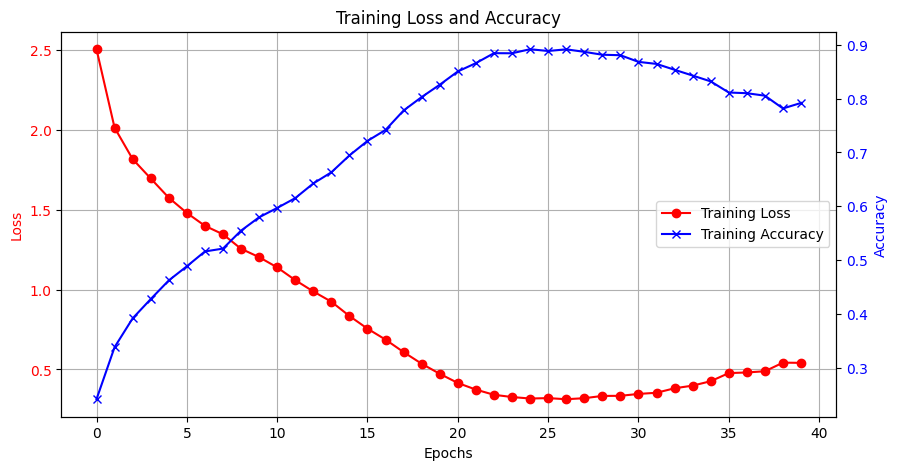

maximum GAP score achieved with 89.2033% at epoch 25


In [12]:
import numpy as np
plot_metrics(train_loss, train_gap)
print(f"maximum GAP score achieved with {round(max(train_gap), 6) * 100}% at epoch {np.argmax(train_gap) + 1}")

In [13]:
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, device)

Evaluating: 100%|██████████| 46/46 [00:03<00:00, 14.56it/s, avg_loss=0.1306, avg_acc=0.57]


 Test Loss: 2.0865729308646657, Accuracy: 0.5727891156462585


In [14]:
path_to_save_log = "/content/drive/MyDrive/cs444-final-project/project/models/baselines/train_logs/SquuzeNet_base_ep=25_best_model_log.json"
save_metrics(train_loss, train_accuracy, train_gap, path_to_save_log)